In [1]:
%load_ext tensorboard

In [2]:

from tensorflow.data import AUTOTUNE
import tensorflow_datasets as tfds

from auramask.losses import ReFaceLoss
from auramask.metrics import PerceptualSimilarity, EmbeddingDistance
from auramask.models import AuraMask, FaceEmbedEnum

from keras_cv.layers import Resizing, Rescaling, Augmenter
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping

import tensorflow as tf

from datetime import datetime

LOG_DIR = 'logs/nocrop/' + datetime.now().strftime("%Y%m%d-%H%M%S")
DEBUG=False
train_writer = tf.summary.create_file_writer(LOG_DIR)
# tf.debugging.experimental.enable_dump_debug_info(LOG_DIR)

2024-02-21 22:47:51.064170: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-21 22:47:51.101670: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 22:47:51.101692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 22:47:51.102590: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-21 22:47:51.108916: I tensorflow/core/platform/cpu_feature_guar

Using TensorFlow backend


2024-02-21 22:47:54.162121: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-21 22:47:54.198205: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-21 22:47:54.199784: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Inputs

## Victim Models (F)

In [3]:
F = [
  FaceEmbedEnum.ARCFACE
]

## Image Dataset (X)

In [4]:
ds, info = tfds.load('lfw',
                     decoders=tfds.decode.PartialDecoding({
                       'image': True,
                     }),
                     with_info=True,
                     download=True,
                     as_supervised=False)

In [5]:
augmenter = Augmenter(
  [
    Rescaling(1./255),
    Resizing(128,128),
  ]
)

def preprocess_data(images, augment=True):
  inputs = {"images": images}
  outputs = augmenter(inputs)
  return outputs['images'], outputs['images']

## Hyperparams

In [6]:
alpha = 2e-4
epsilon = 0.01
l = 0.
BATCH_SIZE = 32
EPOCH = 500  # ReFace training
# EPOCH = 2

# Training

## Training Dataset

In [7]:
train_ds = ds['train']

In [8]:
train_ds = train_ds.batch(BATCH_SIZE).map(
  lambda x: preprocess_data(x['image']),
  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

2024-02-21 22:47:56.333383: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


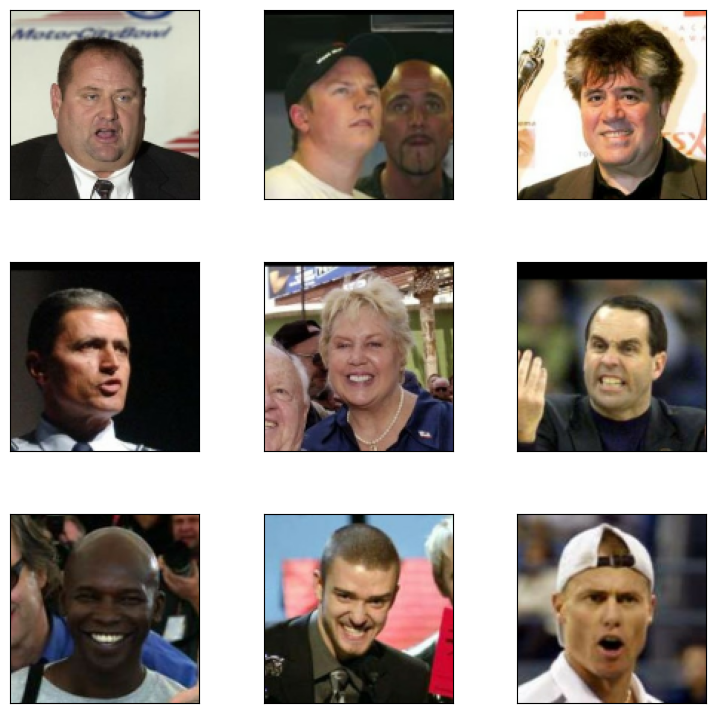

In [9]:
fig = tfds.show_examples(train_ds, info, is_batched=True)

### Initialized ATN ($N_{theta}$)

In [10]:
model = AuraMask(n_filters=32, n_dims=3, eps=epsilon)

In [11]:
t_loss = ReFaceLoss(F=F, l=l)
lpips = PerceptualSimilarity(model=t_loss.lpips.model)
floss = EmbeddingDistance(F=t_loss.embeddist.F, F_set=t_loss.embeddist.F_set)

model.compile(
  optimizer=Adam(learning_rate=alpha),
  loss=t_loss,
  run_eagerly=DEBUG,
  metrics=[lpips, floss]
)

In [12]:
for batch in train_ds.take(1):
  altered = model(batch[0])

2024-02-21 22:48:00.277792: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-02-21 22:48:00.318226: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-02-21 22:48:00.373872: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-21 22:48:00.692659: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [13]:
import matplotlib.pyplot as plt

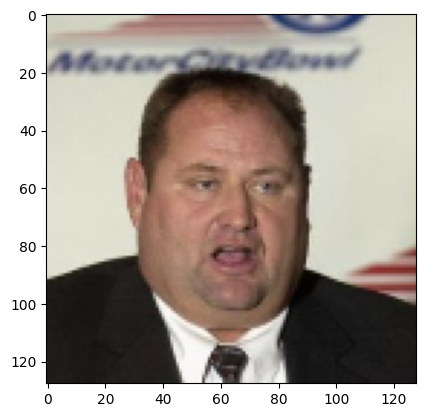

In [14]:
plt.imshow(altered[0,...])
plt.show()

In [15]:
tensorboard_callback = TensorBoard(log_dir=LOG_DIR, write_images=True, update_freq=1, histogram_freq=1)
early_stop = EarlyStopping(monitor='loss', patience=3)

In [16]:
training_history = model.fit(
  x=train_ds,
  batch_size=BATCH_SIZE,
  callbacks=[tensorboard_callback, early_stop],
  epochs=EPOCH,
  verbose=1,
  use_multiprocessing=True
)

Epoch 1/500


2024-02-21 22:48:20.513022: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inAuraMask/UEncoder/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-21 22:48:26.627644: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff79c20a1e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-21 22:48:26.627676: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A10, Compute Capability 8.6
2024-02-21 22:48:26.632379: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708555706.727723  975359 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


414/414 [==============================] - 145s 257ms/step - loss: 0.9981 - Lpips: 0.5043 - embed_dist: -207.8614
Epoch 2/500
414/414 [==============================] - 100s 241ms/step - loss: 0.9974 - Lpips: 0.4882 - embed_dist: -207.5694
Epoch 3/500
414/414 [==============================] - 100s 241ms/step - loss: 0.9974 - Lpips: 0.4877 - embed_dist: -207.5172
Epoch 4/500
414/414 [==============================] - 100s 241ms/step - loss: 0.9974 - Lpips: 0.4877 - embed_dist: -207.4968
Epoch 5/500
193/414 [============>.................] - ETA: 53s - loss: 0.9973 - Lpips: 0.2273 - embed_dist: -96.7624

KeyboardInterrupt: 

In [ ]:
tf.summary.flush()

In [ ]:
model.metrics

In [ ]:
training_history.history.keys()

In [ ]:
for batch in train_ds.take(1):
  altered = model(batch[0])

In [ ]:
plt.imshow(altered[0,...])
plt.show()

In [ ]:
%tensorboard --logdir logs/scalars